In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Load data

## Dataset

In [15]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

X_train, y_train = np.array(data["train_set"]['review']), np.array(data["train_set"]['polarity'])
X_val, y_val = np.array(data["val_set"]['review']), np.array(data["val_set"]['polarity'])
X_test, y_test = np.array(data["test_set"]['review']), np.array(data["test_set"]['polarity'])
class_names = data['class_names']

print("LEN TRAIN: "+ str(len(X_train)))
print("LEN VAL: "+ str(len(X_val)))
print("LEN TEST: "+ str(len(X_test)))

LEN TRAIN: 179981
LEN VAL: 10011
LEN TEST: 10008


# Model selection

## First model

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()), # Default parameters
    ('clf', LogisticRegression(n_jobs=-1, verbose=1)),
])

tfidf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.7s finished


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

## Prediction

In [17]:
some_index = 0
some_review = X_val[some_index]
print(some_review)
print()
print("True Polarity:", class_names[y_val[some_index]])

Pour les fans de sport automobile,le cinéma n'offre pas grand chose à se mettre sous le pneu. Alors,quand un film du genre de "Driven"(2001) débarque sur les écrans... avant de déchanter lourdement. Premièrement,cet action movie du désormais désolant Renny Harlin utilise des monoplaces d'IndyCar et non des Formule 1. Deuxièmement,les personnages sont unidimensionnels,et agaçent par leur gentillesse caractérisée. On en viendrait presque à espérer une bonne vieille opposition manichéenne. Troisièmement,les courses ne sont pas du tout réalistes,entre les dépassements impossibles et les accidents aux images de synthèse plus voyantes que sur un jeu vidéo. Sylvester Stallone,à près de 60 ans ne peut être crédible en pilote chevronné! Mais parce que c'est un film sur l'univers du sport auto,assez ludique il faut bien l'admettre,je ne le démolirais pas trop.

True Polarity: Negative


In [18]:
some_prediction = tfidf_clf.predict([some_review, ])
print("Predicted Polarity:", class_names[some_prediction[0]]) # Good prediction !

Predicted Polarity: Negative


In [19]:
from sklearn import metrics

# Predicting training dataset
y_pred = tfidf_clf.predict(X_train)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred))

# Predicting with a test dataset

y_pred = tfidf_clf.predict(X_val)
print("Validation Accuracy:", metrics.accuracy_score(y_val, y_pred))
print()
print(metrics.classification_report(y_val, y_pred, target_names=class_names.values()))

Training Accuracy: 0.9408381995877343
Validation Accuracy: 0.9313754869643392

              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      5164
    Positive       0.92      0.94      0.93      4847

    accuracy                           0.93     10011
   macro avg       0.93      0.93      0.93     10011
weighted avg       0.93      0.93      0.93     10011



## Grid Search

In [12]:
from sklearn.model_selection import PredefinedSplit

# Grid-search on validation set.
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
validation_indexes = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold=validation_indexes)

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'tfidf__lowercase': (True, False),
     'tfidf__ngram_range': [(1, 1), (1, 2)],
     'tfidf__max_df': [0.60, 0.65, 0.70, 0.75, 0.85, 1],
     'clf__C': np.logspace(-4, 4, 10),
}

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(penalty='l2', n_jobs=-1, verbose=1)),
])

grid_search = GridSearchCV(
    tfidf_clf, param_grid, cv=ps, 
    scoring='accuracy', return_train_score=True, 
    n_jobs=-1, verbose=1
)

grid_search.fit(X, y)

Fitting 1 folds for each of 240 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_rang

In [39]:
print(grid_search.best_params_) # pprint ?
print(grid_search.best_score_)

best_clf = grid_search.best_estimator_

{'clf__C': 1291.5496650148827, 'tfidf__lowercase': True, 'tfidf__max_df': 0.65, 'tfidf__ngram_range': (1, 2)}
0.9225580814389208


Thanks to grid search,  validation accuracy is now ~2 percents higher than before !

# Training best model

In [20]:
best_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True, ngram_range=(1, 2),
        max_df=0.65
    )),
    ('clf', LogisticRegression(
        C=1300, penalty='l2', 
        n_jobs=-1, verbose=1
    )),
])

best_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   52.2s finished


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.65, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1300, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

## Results

In [22]:
y_pred = best_clf.predict(X_val)
print("Val Accuracy: {:.2f}".format(metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(metrics.f1_score(y_val, y_pred)))
print()

report = metrics.classification_report(
    y_val, y_pred, 
    target_names=class_names.values()
)
print(report)

Val Accuracy: 0.94
Val F1-Score: 0.94

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95      5164
    Positive       0.94      0.95      0.94      4847

    accuracy                           0.94     10011
   macro avg       0.94      0.94      0.94     10011
weighted avg       0.94      0.94      0.94     10011



## Learning curves

In [42]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y, cv=ps, 
    scoring='accuracy',n_jobs=-1,verbose=1,
    # 50 different sizes of the training set
    train_sizes=np.linspace(0.01, 1.0, 50)
)

[learning_curve] Training set sizes: [  119   362   604   847  1089  1331  1574  1816  2058  2301  2543  2786
  3028  3270  3513  3755  3997  4240  4482  4724  4967  5209  5452  5694
  5936  6179  6421  6663  6906  7148  7391  7633  7875  8118  8360  8602
  8845  9087  9329  9572  9814 10057 10299 10541 10784 11026 11268 11511
 11753 11996]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


In [43]:
#import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def plot_learning_curves(train_sizes, train_scores, test_scores, figsize=(10,7), fontsize=14):
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    fig = plt.figure(figsize=figsize)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, color="g", label="Validation score")

    # Draw bands
    #plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    #plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD") 

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="lower right")  
    
       
    return fig

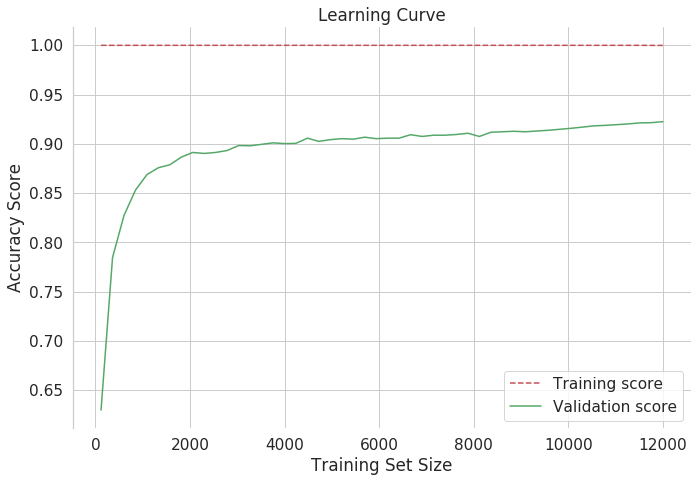

In [46]:
fig = plot_learning_curves(train_sizes, train_scores, test_scores)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/learning_curves.png', dpi=200)

We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples.

## Error analysis

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

def print_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Confusion matrix

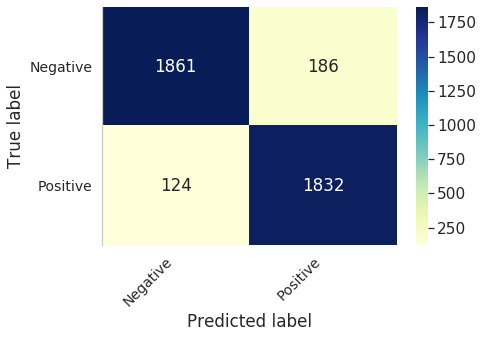

In [59]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_val, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/val_confusion_mx.png', dpi=200)

### False Positive / Negative

In [49]:
false_pos = X_val[(y_val == -1) & (y_pred == 1)]
false_neg = X_val[(y_val == 1) & (y_pred == -1)]

In [50]:
pd.DataFrame(false_pos[:5])

,0
0,"J'y suis allée par affection pour Ramzy et pour Antony Sonigo, que j'aimerai bien un jour voir dans un bon film... Doux rêve inaccessible ? Encore une comédie française lamentable. les auteurs du scénario croient donc s'adresser à des spectateurs quiont du pop corn à la place des neurones ? une comedie triste : tout ce qui fait fuir."
1,"Scènes montrant l'homosexualité des 2 jeunes sont désagréables à regarder. La critique sociale est faible. Tout fait trop théâtre, on ne change presque jamais de lieu... Day-Lewis très bon."
2,"Après l'énorme réussite du premier volet, on était en droit d'attendre mieux de cette suite. En effet, ce film est décevant. Tout d'abord le choix du contexte : un groupe de militaires ce retrouvant piégé dans ces collines. Le fait que ce soit des Hommes armés et entrainés qui se fassent massacrer fait que l'on se sent moins impliqué et moins horrifié par ce qui leurs arrivent. De plus si c'est cela l'armée américaine.... no comment u_u'. Les personnages, que ce soit les humains ou les mutants, sont moins développés. Néanmoins les meurtres sont sympas et bien sanglants et après tout on vient voir ce genre de film avant tout pour cela."
3,"les promesses de ce film furent grandes: Film tiré d'une histoire vraie d'un homme de couleur à l'heure noire des USA. Il n'en fut rien... Ce film nous montre l'humanité sous son pire jour. Comme si seuls les clivages existaient et avaient du sens: Soit tu es un méchant blancs anti-noirs (tous les blancs détestent les noirs), soit tu es noir et dans ce cas 2 catégories: le noir animal et soumis, version hybride d'un labrador et d'un semi homme, soit une bête assoiffée de violence. Vous l'aurez compris, dans ce film, peu de place pour l'Humanité (avec un grand H). L'égalité n'a pas sa place. L'Histoire (avec un grand H) n'y sera jamais incluse. Ou est le discours de Martin Luther King ayant vu les Hommes (peu importe leur couleur) se lever pour l'égalité? Qu'en est il de son prix nobel? Pourquoi seule sa mort et celle de Kennedy (présenté comme l'unique président des USA pour l'égalité) ne fut elle mise en avant??? Qu'en est il de la loi sous Johnson visant ayant institué l'égalité devant le vote? De la décoration posthume de King par Carter marquant le symbole d'une union du peuple Américain? Qu'en est il de Clinton? Des mobilisation pro Angela Davis ayant mobilisé blancs et noirs lors de son éviction de UCLA??? On nous parle de droits et de non droits du peuple noir... Pas d'égalité de l'Homme (avec un grand H j'insiste) dans sa diversité, comme si il n'en fut, n'en est, et n'en sera question à aucun moment de notre Histoire. Moment fort? lorsque ce brave majordome obtient une promotion après 20 ans de bons et loyaux services, suite à l'approbation d'un président présenté comme pro Apartheid en Afrique du Sud. Veut on nous dire que seule sa loyauté rend cela possible? L'humanité et l'égalité se gagnerait elle et ne serait donc pas fondamentale? La foule du cinéma applaudira ce passage, le tour de passe passe et lavage de cerveau a fonctionné! Nous voici face à une nouvelle manipulation extrêmes de nos simples esprits visant à nous enfermer dans un passé ne nous ressemblant pas (plus?), auquel la plupart d'entre nous n'a pas participé, mais dans lequel un microcosme veut nous enfermer pour mieux nous faire culpabiliser et nous manipuler: Seigner, j'ai honte de mon héritage, président, montrez moi comment nous racheter... L'Homme est EGAL! Quand va-t-on enfin véhiculer un message d'espoir? Quand va-t-on arrêter de se divertir/délecter de ces périodes sombres d'un passé que nous voulons tous oublier, pour se concentrer vers un futur commun?"
4,"Certes Marina Foïs joue incroyablement bien, certes le sujet dont traite Darling est un sujet qu'il faut traiter... Cependant il est traité avec bien trop de dureté pour moi. Difficile à regarder, pas assez de réserve, tout est trop explicite, de nombreuses choses auraient pu être comprises sans être montrées, et auraient ét

In [51]:
pd.DataFrame(false_neg[:5])

,0
0,Le titre original aurait sans doute mieux convenu tant le message est aujourd'hui universel. Jia nous donne des nouvelles de la Chine et sans doute un peu du Monde.
1,"Une exelante comedie et bonne idee de la part de louis de funes,il a eu l' idee de refaire l avare, la comedie de moliere,sous forme de film."
2,"Pas vraiment mon genre de films car pas de SF, de comique ou d'action.Mais alors, qu'est-ce qu'il est prenant ! On nage dans le glauque mais l'imprégnation dans cette atmosphère est pudique.C'est un film conçu par des gens matures.Du coup j'irais voir les autres films du réalisateur."
3,"Je l'ai regardé à l'instant avec mon petit frère sur internet. Je m'attendais à un navet comme il s'en fait beaucoup depuis de nombreuses années et franchement j'ai étais surpris. Bien entendu ce n'était pas un film exceptionnel mais la qualité était bonne, les mises en scènes intéressantes, les effets spéciaux étaient loin d'être mauvais et j'ai eu mon lot de ""oh bordel"". Seul point négatif : beaucoup de scènes étaient prévisibles et on s'en amusait à parier sur beaucoup de choses. Si il fallait noter concrètement j'aurai mis la note de 6,75/10"
4,"Je ne serais pas dur dans ma notation car il ne faut pas bouder son plaisir : c'est divertissant! De plus, le duo d'acteurs est convaincant, et les seconds rôles qui les entourent également. Sans être pliant, c'est marrant et on ne s'ennuie pas spécialement durant 1H30. Mais alors, c'est quoi le hic??? Bin c'est que sortit en Aout 1998, ""Un cadavre sur le campus"" est littérallement le copier-coller de ""Cursus fatal"" , sortit jour pour jour 1 an avant...donc piquer le scénario d'un autre, pour le ressortir l'année d'après en pleine période d'été comme son prédecesseur, j'appelle ça du commerce pur et simple, et non du cinéma. Tiens, en fait je suis un peu dur! Notons tout de même que le film prend une tournure nettement moins morbide que ""Cursus Fatal"", et se veut plus comique, et donc dire que je n'ai pas passé un bon moment serait faux."


# Testing best model

In [52]:
y_pred = best_clf.predict(X_test)
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 0.92
Test F1-Score: 0.92

              precision    recall  f1-score   support

    Negative       0.93      0.90      0.91      2018
    Positive       0.90      0.93      0.92      1983

    accuracy                           0.92      4001
   macro avg       0.92      0.92      0.92      4001
weighted avg       0.92      0.92      0.92      4001



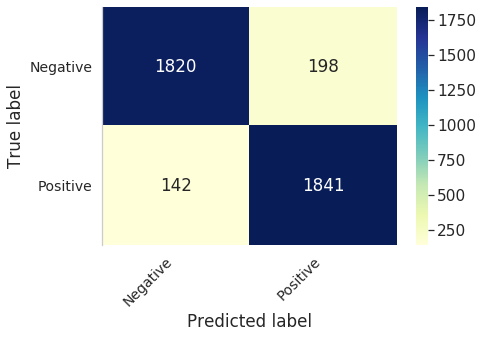

In [53]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/test_confusion_mx.png', dpi=200)